# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language(could be sequences text or speech)

Another common term for NLP problems is sequence to sequence problems(seq2seq).

## Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1b1c460d-aceb-84a8-d8d5-755e421b5549)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-07-25 08:51:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-25 08:51:18 (125 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's Introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

Original source: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-07-25 08:51:22--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   723KB/s    in 0.8s    

2023-07-25 08:51:23 (723 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

Another straight forward way is using pandas.


In [ ]:
import pandas as pd

train_df  = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
# Shuffle training dataframe
train_df_shuffled  = train_df.sample(frac=1 , random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many example of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _,text, target = row
  print(f"Target:{target}", "{real disaster}" if target >0 else"{not real disaster}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target:1 {real disaster}
Text:
@TradCatKnight (1) Russia may have played into reason but that link is BS.  Okanowa was bloody and mainline invasion looked like a bloody

---

Target:0 {not real disaster}
Text:
Anyone else think that Stephen sounds like Andy Dick when he gets excited? The difference being... I actually like Stephen. #MasterChef

---

Target:1 {real disaster}
Text:
Ûª93 blasts accused Yeda Yakub dies in Karachi of heart attack http://t.co/mfKqyxd8XG #Mumbai

---

Target:1 {real disaster}
Text:
Really cannot condemn an entire group based on the actions of a few.. A heart-warming unity against terrorism.. http://t.co/HHPvPaEL4n

---

Target:1 {real disaster}
Text:
'Money can't buy happiness' is just a lie we tell poor people to keep them from rioting.

---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data  into trainng data and validation data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size= 0.1,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things to do before building model is to convert text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)   

### Text vectorization(tokenization)

In [ ]:
train_sentences[:2]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma'], dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=200, #how many words in vocabulary(automatically add<OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # Create groups of n-words?
                                    output_mode="int",#how to map tokens to numbers
                                    output_sequence_length = None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens(words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in vocab
max_length = 15  # max length our senquences will be(e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my streets!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,    9,    3,  232,    4,   13, 1585,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Orginal text:\n {random_sentence}\\n\nVectorized version:")
text_vectorizer([random_sentence])

Orginal text:
 The Threat | Anthrax | CDC http://t.co/q6oxzq45VE via @CDCgov\n
Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   2, 1170, 1096, 3120,    1,   49,    1,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Get a unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()# get all of the unique words in train sentences
top_5_words = words_in_vocab[:5] # Get the most common words
bottom_5_words= words_in_vocab[-5:] # Get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating Embeding  using an Embedding layer

To make embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras  import layers

embedding = layers.Embedding(input_dim = max_vocab_length, #set input length
                             output_dim = 128, #output shape
                             input_length= max_length) #how long is each input

embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Orginal text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embeded the random sentence (turn it into vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Orginal text:
 5 dead 3 missing 103 families evacuated due to floods in Bukidnon: ... http://t.co/z0hSckvySN        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-1.6444147e-02, -1.5463628e-02,  4.9949776e-02, ...,
         -4.5866262e-02,  2.1530975e-02, -1.4095020e-02],
        [ 3.9504718e-02,  1.9827273e-02,  4.8214603e-02, ...,
         -2.1952678e-02, -3.0169129e-02, -3.7596919e-02],
        [ 2.1155249e-02, -2.4420917e-02, -1.8642295e-02, ...,
          3.1990495e-02, -4.2600919e-02,  2.1951351e-02],
        ...,
        [-4.9050462e-02, -3.0096257e-02,  1.9511469e-03, ...,
         -3.6985587e-02, -4.0231775e-02,  4.4315640e-02],
        [ 3.4126528e-03, -7.3449984e-03, -4.5322254e-04, ...,
          7.8834593e-05, -3.2389879e-02, -3.1147493e-02],
        [ 3.4126528e-03, -7.3449984e-03, -4.5322254e-04, ...,
          7.8834593e-05, -3.2389879e-02, -3.1147493e-02]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01644415, -0.01546363,  0.04994978,  0.0308562 ,  0.0499247 ,
        -0.00339558,  0.04738719, -0.02118403, -0.00664178, -0.04402002,
        -0.01025955,  0.04364548, -0.00261605,  0.03750518,  0.04507119,
         0.04950419,  0.03168182, -0.03539562,  0.02131938, -0.04775358,
        -0.01951294, -0.00105668,  0.0204319 ,  0.04914986,  0.02206853,
        -0.03300627,  0.01590607,  0.03485414, -0.00083971, -0.02725501,
         0.02413579, -0.03939762, -0.04305265, -0.04472705, -0.04892511,
         0.04112304,  0.01131169,  0.04690761,  0.02685435,  0.00443008,
         0.02579624, -0.0493249 ,  0.04137886, -0.03932165,  0.02730567,
         0.00351886, -0.00951732, -0.04163688,  0.04292238, -0.01340242,
         0.01225712, -0.02250073, -0.04287071,  0.04726125, -0.04557209,
        -0.02201235, -0.03342058,  0.02039105,  0.0368377 ,  0.00905479,
         0.00779531,  0.0388268 , -0.01577944, -0.03748375,  0.01261219,
  

## Modelling a text dataset(running a series of experiments)

Now we've got way ti turn our next sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.
* Model 0: Naive Bayes(baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network(dense model)
* Model 2: LSTM(Long Short-Term Memory) model(RNN)
* Model 3: GRU(Gated Recurrrent Unit) Model(RNN)
* Model 4: Bidirectional-LSTM model(RNN)
* Model 5: 1D Convolutional Neural Network(CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor(using transfer learning for NLP)
* Model 7: Same as model with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:
* Create a model
* Build a model
* Fit a model
* Evaluate the model


### Model 0: Naive Bayes(baseline)

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF(Term frequency - inverse document frequency, i.e. tf-idf = tf * idf) formula to convert our words to numbers.

> **Note:** It's common practice to use non-Dl algorithms as a baseline because of their speed and then later using Dl to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [ ]:
# Create a tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers usinf tfidf
                    ("clf", MultinomialNB()) # Model the text
                    ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Calculating accuracy and generating classification report from test data
# Testing our Naive Bayes classifier model with test data -

# predict the validation data

baseline_preds = model_0.predict(val_sentences)

# compute the performance measures
score1 = metrics.accuracy_score(val_labels, baseline_preds)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(val_labels, baseline_preds,
                                            target_names=['Positive', 'Negative']))

print("confusion matrix:")
print(metrics.confusion_matrix(val_labels, baseline_preds))

print('------------------------------')

accuracy:   0.793
              precision    recall  f1-score   support

    Positive       0.75      0.93      0.83       414
    Negative       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762

confusion matrix:
[[386  28]
 [130 218]]
------------------------------


### Creating an evaluation function for model experiments
We could evalute all our model's predictions with different metrics every time, however, this will be troublesome and could easily be done with a function..

Let's create one to compare model's predictions with the truth labels using following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall" : model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback(need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding (x) # Create a embedding of the numberized inputs
x = layers.GlobalMaxPooling1D()(x) # Condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid fucntions
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])


Saving TensorBoard log files to: model_logs/model_1_dense/20230725-085128
Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.6338 - accuracy: 0.6600 - val_loss: 0.5690 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4654 - accuracy: 0.8254 - val_loss: 0.4738 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8753 - val_loss: 0.4486 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.9082 - val_loss: 0.4543 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1964 - accuracy: 0.9353 - val_loss: 0.4662 - val_accuracy: 0.7940


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4662 - accuracy: 0.7940


[0.4662427604198456, 0.7939632534980774]

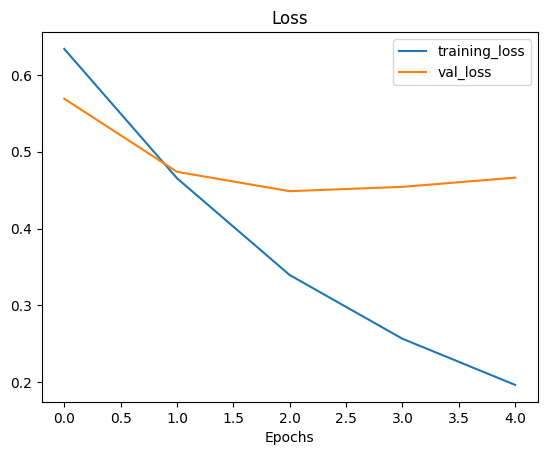

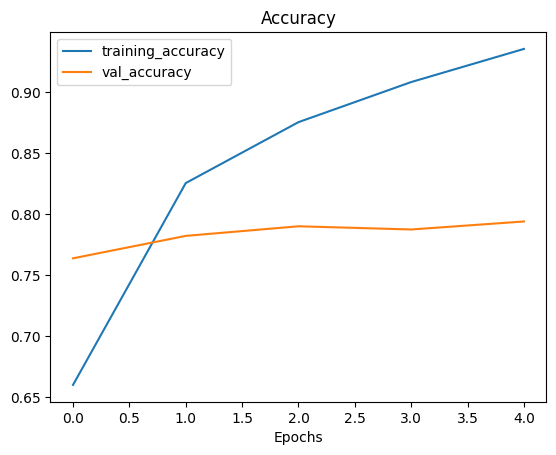

In [ ]:
plot_loss_curves(model_1_history)

In [ ]:
model_1_pred_prob = model_1.predict(val_sentences)

24/24 [==============================] - 0s 2ms/step


In [ ]:
# convert model prediction probabilites to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_prob))

In [ ]:
# calculate model-1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.7993947876674304,
 'recall': 0.7939632545931758,
 'f1': 0.7909943685590214}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True, False,  True,  True])

### Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model summmary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get teh weigth matriz of embedded layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) #same size as vocab size and embedding_dims (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [ ]:
# Create embedding files(from word embedding documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue #skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks(RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Resources** of overview of internals of a recurrent neural network:
* MIT's sequence modelling lecture http://introtodeeplearning.com/
* Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = Long Short Term Memory(one of the most popular cells)

Structure of an RNN typically looks like this:
> `Input(text) -> Tokenize -> Embedding -> Layers(RNNs/dense) -> Output (label probability)`

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20230725-085140
Epoch 1/5
215/215 [==============================] - 22s 77ms/step - loss: 0.3791 - accuracy: 0.8386 - val_loss: 0.4884 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2408 - accuracy: 0.9061 - val_loss: 0.4967 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1781 - accuracy: 0.9339 - val_loss: 0.5766 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1347 - accuracy: 0.9527 - val_loss: 0.6836 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1047 - accuracy: 0.9632 - val_loss: 0.7569 - val_accuracy: 0.7651


In [ ]:
# Make prediction with lstm model
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.3964889 ],
       [0.8225937 ],
       [0.9991635 ],
       [0.09852457],
       [0.00887095],
       [0.99929094],
       [0.70860314],
       [0.99972004],
       [0.9995925 ],
       [0.52685153]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_preds_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'precision': 0.76472972449374,
 'recall': 0.7650918635170604,
 'f1': 0.7644302589305015}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers to stack on top of each other, you need return_sequences=True
# x = layers.LSTM(64)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230725-085224
Epoch 1/5
215/215 [==============================] - 15s 56ms/step - loss: 0.2139 - accuracy: 0.9101 - val_loss: 0.6547 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0992 - accuracy: 0.9651 - val_loss: 0.7198 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0777 - accuracy: 0.9718 - val_loss: 0.8604 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0664 - accuracy: 0.9740 - val_loss: 1.0376 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0586 - accuracy: 0.9764 - val_loss: 1.0433 - val_accuracy: 0.7638


In [ ]:
# Make some prediction from GRU MODEL
model_3_preds_probs = model_3.predict(val_sentences)
model_3_preds_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.00822324],
       [0.8236576 ],
       [0.99951017],
       [0.03913191],
       [0.00178042],
       [0.99923813],
       [0.4781656 ],
       [0.9998348 ],
       [0.9997466 ],
       [0.7463558 ]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_preds_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.769789645859485,
 'recall': 0.7637795275590551,
 'f1': 0.7596002422774075}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right(just like you'd read ENGLISH sentence) however, a bidirectional RNN goes from right to left as well as left to right


In [ ]:
# Build an biderectional rnn
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional_rnn")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params:

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20230725-085252
Epoch 1/5
215/215 [==============================] - 17s 56ms/step - loss: 0.1355 - accuracy: 0.9524 - val_loss: 0.9669 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0622 - accuracy: 0.9752 - val_loss: 1.3397 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0532 - accuracy: 0.9755 - val_loss: 1.4023 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0508 - accuracy: 0.9784 - val_loss: 1.3662 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0465 - accuracy: 0.9790 - val_loss: 1.5025 - val_accuracy: 0.7638


In [ ]:
# Make some prediction from GRU MODEL
model_4_preds_probs = model_4.predict(val_sentences)
model_4_preds_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.9423297e-03],
       [6.8374199e-01],
       [9.9997079e-01],
       [5.5179436e-02],
       [9.3502940e-06],
       [9.9925286e-01],
       [8.6536056e-01],
       [9.9998212e-01],
       [9.9998069e-01],
       [1.9877857e-02]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7669591618844255,
 'recall': 0.7637795275590551,
 'f1': 0.760774054689911}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs fro images but images are typically 2D(height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D

The typical structure of a Conv1D model for sequences(in our case, text):
`Inputs(text) -> Tokenization -> Embedding -> layer(s) (typically Conv1D + pooling) -> Outputs (class probability)`


### Model 5: Conv1D

In [ ]:
# Build an 1d convolutional neural network
from tensorflow.keras import layers

inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,kernel_size=5,strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5= tf.keras.Model(inputs, outputs, name="model_4_bidirectional_rnn")

In [ ]:
model_5.summary()

Model: "model_4_bidirectional_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)   

In [ ]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230725-085322
Epoch 1/5
215/215 [==============================] - 19s 57ms/step - loss: 0.1482 - accuracy: 0.9572 - val_loss: 0.8778 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0763 - accuracy: 0.9723 - val_loss: 0.9903 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0593 - accuracy: 0.9777 - val_loss: 1.0902 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0555 - accuracy: 0.9759 - val_loss: 1.1210 - val_accuracy: 0.7454
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0516 - accuracy: 0.9796 - val_loss: 1.1401 - val_accuracy: 0.7467


In [ ]:
# Make some prediction from conv1d MODEL
model_5_preds_probs = model_5.predict(val_sentences)
model_5_preds_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[9.7567700e-02],
       [9.2416054e-01],
       [9.9996960e-01],
       [5.4436013e-02],
       [1.5492737e-05],
       [9.6047884e-01],
       [9.2057973e-01],
       [9.9991536e-01],
       [9.9999726e-01],
       [2.8340998e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_preds_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 74.67191601049869,
 'precision': 0.7472349343954156,
 'recall': 0.7467191601049868,
 'f1': 0.7447670293859548}

## Model 6: TensorFlow Hub Pretrained Universal Sentence Encoder
Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["this is sample sentence"])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.0460109   0.00065932  0.00832609  0.02152405 -0.0759968   0.0036498
  0.07327703  0.06060008  0.01366106  0.04317779 -0.03191425  0.00027275
 -0.02205695  0.06926249 -0.00672919 -0.08021186 -0.01766709 -0.01559486
 -0.02493958 -0.02838084  0.04707995  0.06923255 -0.03689378  0.05911254
 -0.08802158  0.07103123  0.00706375 -0.08433077  0.03035994 -0.04483438
  0.01953263 -0.00265947 -0.03587337 -0.02240224 -0.0897397  -0.01269876
 -0.01073785  0.0155407  -0.0547903   0.02327571 -0.01703735  0.05663254
 -0.0257116   0.06274403 -0.03032716 -0.02318609  0.03854024 -0.00238038
  0.03358924 -0.00319483], shape=(50,), dtype=float32)


In [ ]:
# Create a Keras layer using the USE pretrained layer from tensorflowhub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable= False,
                                        name="USE")


In [ ]:
# Create model using Sequenitial API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [ ]:
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6.history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230725-085445
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5066 - accuracy: 0.7840 - val_loss: 0.4458 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4152 - accuracy: 0.8139 - val_loss: 0.4415 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4006 - accuracy: 0.8216 - val_loss: 0.4307 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3920 - accuracy: 0.8260 - val_loss: 0.4301 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3855 - accuracy: 0.8292 - val_loss: 0.4281 - val_accuracy: 0.8110


In [ ]:
# Make some prediction from USE MODEL
model_6_preds_probs = model_6.predict(val_sentences)
model_6_preds_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.21066171],
       [0.81987697],
       [0.9923619 ],
       [0.21891703],
       [0.7301863 ],
       [0.7500243 ],
       [0.98666984],
       [0.9780899 ],
       [0.94362104],
       [0.11371875]], dtype=float32)

In [ ]:
# Round the preds
model_6_preds = tf.squeeze(tf.round(model_6_preds_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# calculate_results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.811681128461696,
 'recall': 0.8110236220472441,
 'f1': 0.8100711801499202}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAKS DATA FROM VALIDATION/TEST INTO TRAINING SET

# # Create subset of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent)  , len(train_labels_10_percent)

In [ ]:
# Making a better dataset split(no data leakage)
train_10_percent_split = int(0.1 *  len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the number of train labels in updated dataset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Check the number of targets in our subsets of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
], name="model_7_USE_10_percent_data")

model_7.compile(loss="binary_crossentropy",
                metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
history_model_7 = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_USE_10_percent_data_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_data_correct_split/20230725-085509
Epoch 1/5
22/22 [==============================] - 3s 12ms/step - loss: 0.6694 - accuracy: 0.7036
Epoch 2/5
22/22 [==============================] - 0s 12ms/step - loss: 0.5953 - accuracy: 0.8204
Epoch 3/5
22/22 [==============================] - 0s 14ms/step - loss: 0.5191 - accuracy: 0.8307
Epoch 4/5
22/22 [==============================] - 0s 12ms/step - loss: 0.4602 - accuracy: 0.8307
Epoch 5/5
22/22 [==============================] - 0s 12ms/step - loss: 0.4218 - accuracy: 0.8409


In [ ]:
# make dome predictions fro USE model 7 trained on 10 percent data
model_7_preds_probs = model_7.predict(val_sentences)
model_7_preds_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.21647418],
       [0.59081185],
       [0.9066395 ],
       [0.36650386],
       [0.54545975],
       [0.68974614],
       [0.8774498 ],
       [0.81076944],
       [0.8259478 ],
       [0.15002756]], dtype=float32)

In [ ]:
# Convert preds prob to labels
model_7_preds = tf.squeeze(tf.round(model_7_preds_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate the model predcition to true labels
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

In [ ]:
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7769617885542762,
 'recall': 0.7755905511811023,
 'f1': 0.7737412623092624}

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.811681128461696,
 'recall': 0.8110236220472441,
 'f1': 0.8100711801499202}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                 "1_simple_dense": model_1_results,
                                 "2_lstm": model_2_results,
                                 "3_gru" : model_3_results,
                                 "4_biderectional": model_4_results,
                                 "5_conv1D": model_5_results,
                                 "6_tf_hub_use_encoder": model_6_results,
                                 "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results= all_model_results.transpose()

In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

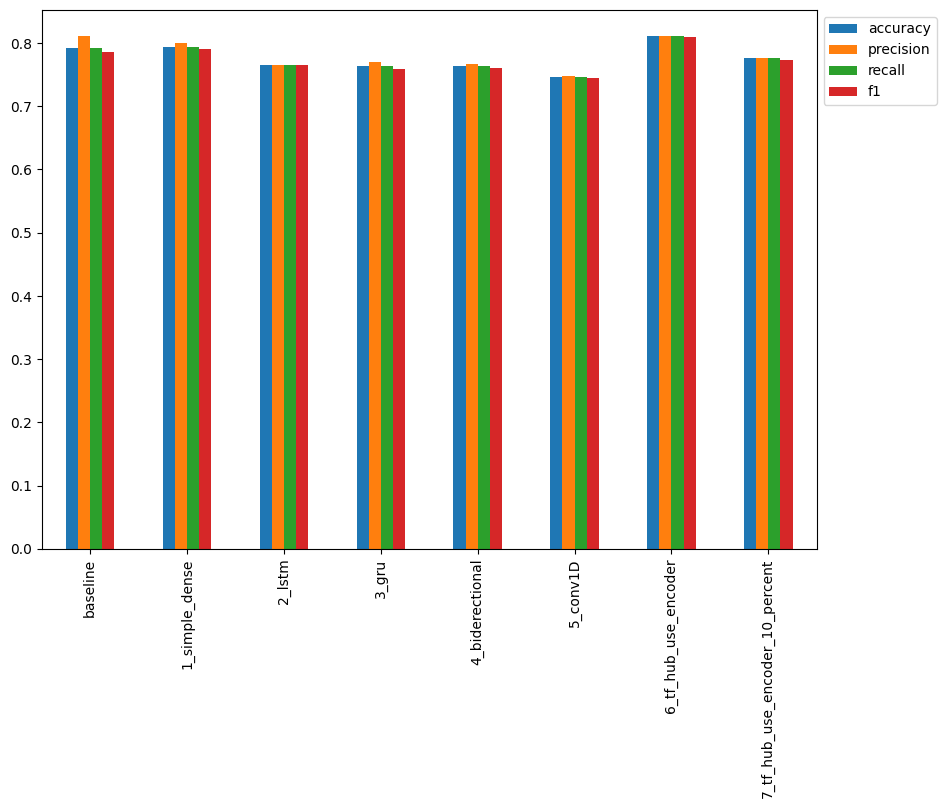

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

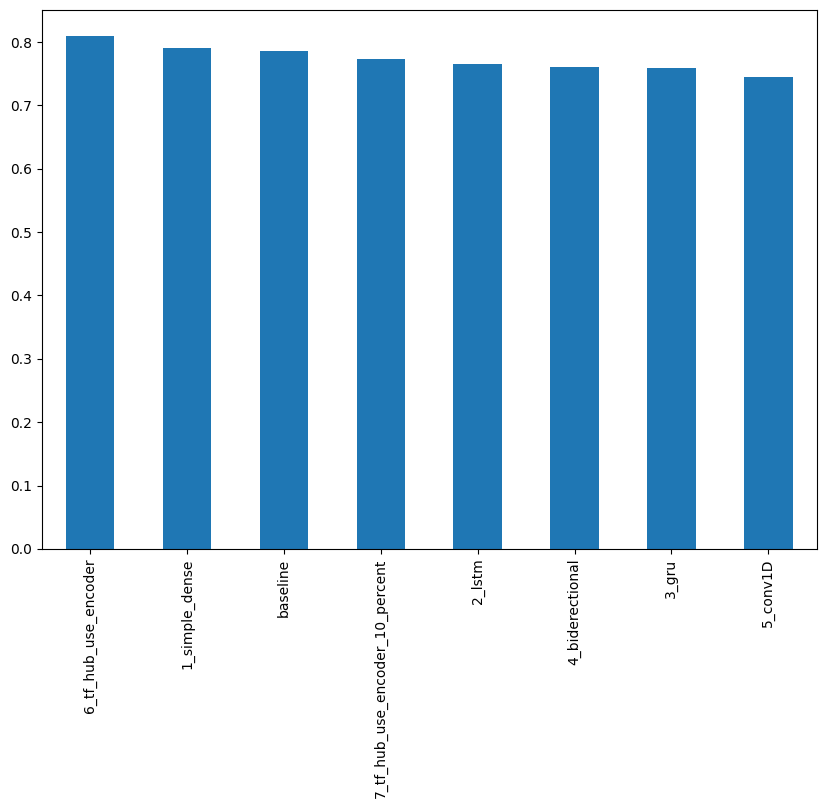

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

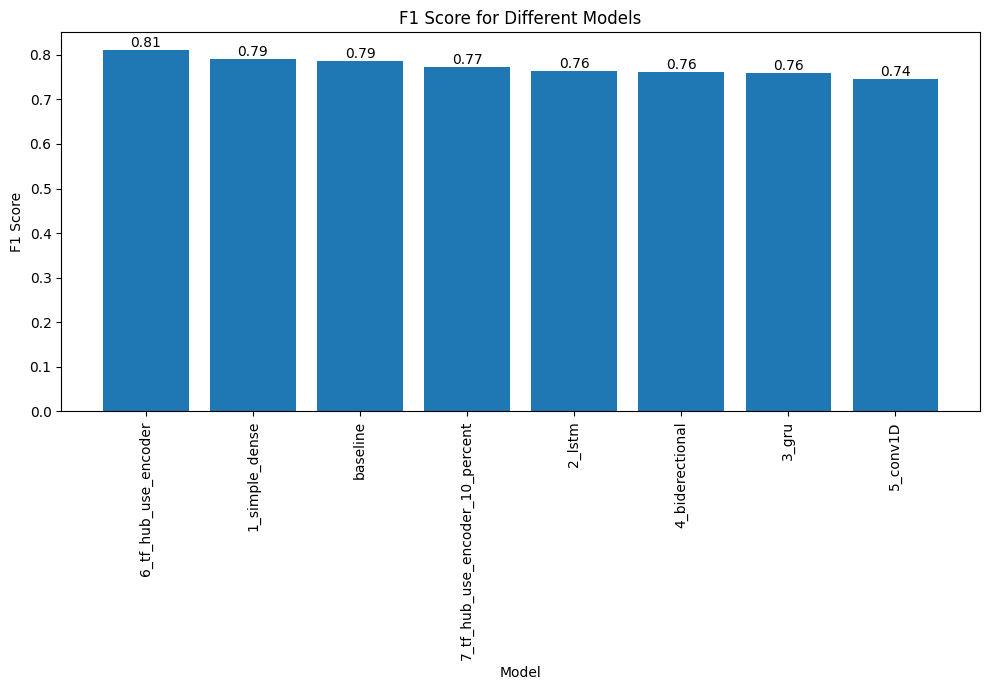

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Sort the DataFrame by "f1" column in descending order
all_model_results_sorted = all_model_results.sort_values("f1", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 7))
bars = plt.bar(all_model_results_sorted.index, all_model_results_sorted["f1"])

# Annotate each bar with its f1 value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Uploading our model training logs to Tensorboard.dev

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments(plus all our other models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
  # --name "NLP Modelling Experiments " \
  # --description "Comparing multiple different types of models architectures on the Kaggle Tweets text classification dataset" \
  # --one_shot #exit the uploader once uploading is finished

View your TensorBoard at https://tensorboard.dev/experiment/WJfaMvfMRa20CJZ3rKWDhQ/

In [ ]:
# See the previous TensorBoard Dev experiment you've run..
# !tensorboard dev list

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following
# !tensorboard dev delete --experiment_id ....

## Saving and loading format
1. The HDF5 format
2. The `SavedModel` format(this is the default when using the TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model = tf.keras.models.load_model("model_6.h5",
                                          custom_objects = {"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4281 - accuracy: 0.8110


[0.42810893058776855, 0.8110235929489136]

Now let's save to the `SavedModel` format

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format(default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4281 - accuracy: 0.8110


[0.4281088709831238, 0.8110235929489136]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong(those will prediction probabilites closest to the opposite class)
For example if a sample have a label of 0 but our model predicts a prediction probability of 0.999(really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-07-25 09:18:42--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  24.3MB/s    in 46s     

2023-07-25 09:19:28 (19.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [ ]:
# Import previosuly trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 19ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences and labels and best performing model predictions labels + probabilites
val_df = pd.DataFrame({"text": val_sentences,
                      "target":val_labels,
                      "pred": model_6_pretrained_preds,
                      "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by prediciton probabilites
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong.head() # these are False positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [ ]:
most_wrong.tail()# they are false negative

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Check the false positives(model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:{text}\n")
  print("------------\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

------------

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

------------

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

------------

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

------------

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

------------

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:@SonofLiberty357 all illuminated by the brightly burning bu

In [ ]:
# Check the false negative(model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:{text}\n")
  print("------------\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:@DavidVonderhaar At least you were sincere ??

------------

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

------------

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text:Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

------------

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:going to redo my nails and watch behind the scenes of desolation of smaug ayyy

------------

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

------------

Target: 1, Pred: 0.0, Prob: 0.04391850158572197
Text:@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-

## Making prediction on test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-------\n")

1/1 [==============================] - 0s 49ms/step
Pred: 0, Prob: 0.3607616722583771
Text:
@crown_769 I'd rather have an ass in fire. At least I'd know whatever I eat will evacuate. Heartburn sticks around.

-------

1/1 [==============================] - 0s 62ms/step
Pred: 1, Prob: 0.7842417359352112
Text:
@Mintechan Hihow are you? There is Keio line on the stationright? BTW do you know the airplane accident near Chofu airport this week?

-------

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.13238899409770966
Text:
Inundation subtle influence distress ideas-the sociologist relative to a doer: Mhl

-------

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.03244573250412941
Text:
@MeganRestivo I am literally screaming for you!! Congratulations!

-------

1/1 [==============================] - 0s 53ms/step
Pred: 0, Prob: 0.35700511932373047
Text:
How as far as landslide high exploit even with statesmanlike cv final draft inaugural?: jGIsAvq

-

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() #Get start time
  model.predict(samples) #make predictions
  end_time = time.perf_counter() #get finish time
  total_time = end_time-start_time # calculate how long predictions took to make all predictions
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calulate Tf Hub sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3615254240003196, 0.0004744428136487134)

In [ ]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.0229153509999378, 3.0072639107529922e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true=val_labels, y_pred=model_6_pretrained_preds)
model_6_pretrained_results


{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

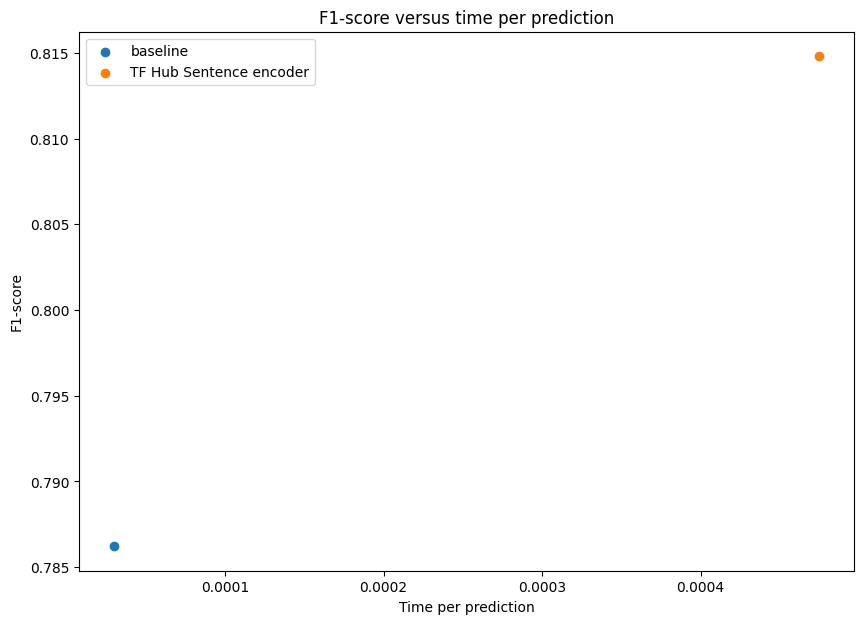

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="TF Hub Sentence encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")
plt.show()